# first train a model

In [1]:
from sklearn.datasets import load_svmlight_file
import numpy as np
import sys
import lightgbm as lgb

In [11]:
svmtrain = load_svmlight_file('./train.libsvm')
svmtest = load_svmlight_file('./test.libsvm')
X_train = svmtrain[0].toarray()
y_train = svmtrain[1]
X_test = svmtest[0].toarray()
y_test = svmtest[1]
lmda = 1.0
eta = 0.1

In [3]:
evals_result = {}
params = {
    "objective":"binary", 
    'metric': 'auc', 
    "lambda_l2": lmda,
    'learning_rate': 0.1
}

In [4]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

clf = lgb.train(
    params,
    lgb_train,
    evals_result=evals_result,
    num_boost_round=200,
    valid_sets=[lgb_train, lgb_eval],
    early_stopping_rounds=10
)

[1]	training's auc: 0.870869	valid_1's auc: 0.874987
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.884095	valid_1's auc: 0.882721
[3]	training's auc: 0.888434	valid_1's auc: 0.88921
[4]	training's auc: 0.896787	valid_1's auc: 0.893384
[5]	training's auc: 0.899858	valid_1's auc: 0.894658
[6]	training's auc: 0.90465	valid_1's auc: 0.897728
[7]	training's auc: 0.906755	valid_1's auc: 0.897818
[8]	training's auc: 0.908352	valid_1's auc: 0.900545
[9]	training's auc: 0.9095	valid_1's auc: 0.899733
[10]	training's auc: 0.911111	valid_1's auc: 0.900505
[11]	training's auc: 0.912552	valid_1's auc: 0.900652
[12]	training's auc: 0.914517	valid_1's auc: 0.900717
[13]	training's auc: 0.915868	valid_1's auc: 0.902026
[14]	training's auc: 0.917167	valid_1's auc: 0.902692
[15]	training's auc: 0.918287	valid_1's auc: 0.903298
[16]	training's auc: 0.919614	valid_1's auc: 0.904895
[17]	training's auc: 0.920872	valid_1's auc: 0.906101
[18]	training's auc: 0.92208	vali

In [5]:
model_info = clf.dump_model()

In [6]:
model_info['tree_info'][0]

{'tree_index': 0,
 'num_leaves': 31,
 'num_cat': 0,
 'shrinkage': 1,
 'tree_structure': {'split_index': 0,
  'split_feature': 0,
  'split_gain': 1363.77001953125,
  'threshold': 0.3755284360762356,
  'decision_type': '<=',
  'default_left': True,
  'missing_type': 'None',
  'internal_value': 0,
  'internal_count': 12000,
  'left_child': {'split_index': 1,
   'split_feature': 3,
   'split_gain': 247.8300018310547,
   'threshold': 298.50000000000006,
   'decision_type': '<=',
   'default_left': True,
   'missing_type': 'None',
   'internal_value': 1.52427,
   'internal_count': 2545,
   'left_child': {'split_index': 8,
    'split_feature': 1,
    'split_gain': 128.54600524902344,
    'threshold': 0.45144156991920453,
    'decision_type': '<=',
    'default_left': True,
    'missing_type': 'None',
    'internal_value': 1.02931,
    'internal_count': 1760,
    'left_child': {'split_index': 9,
     'split_feature': 3,
     'split_gain': 131.32000732421875,
     'threshold': 244.5000000000000

In [14]:
def get_id(d):
    if 'split_index' in d:
        return 'split_{}'.format(d['split_index'])
    else:
        return 'leaf_{}'.format(d['leaf_index'])
    
def extract_tree(tree_list, eta=1.0, lmda=1.0):
    new_tree_list = []
    for idx, tree in enumerate(tree_list):
        nodes = tree['tree_structure'].copy()
        node_list = {}
        node_orders = []
        node_list, node_orders = extract_node(nodes=nodes, node_list=node_list, node_orders=node_orders)
        compute_node_logit(node_list, node_orders, eta=1.0, lmda=1.0)
        compute_node_logit_delta(node_list, node_orders)
        new_tree_list.append(node_list)
    return new_tree_list

def extract_node(nodes, parent=None, node_list={}, node_orders=[]):
    node = {}
    for k, v in nodes.items():
        if isinstance(v, dict):
            next
        else:
            node[k] = v
    
    node['is_leaf'] = not 'split_index' in node
    node['id'] = get_id(node)
    
    node_orders.append(node['id'])
    
    if parent:
        node['parent'] = parent['id']
    else:
        node['parent'] = None
    
    for k, v in nodes.items():
        if isinstance(v, dict):
            node[k] = get_id(v)
            extract_node(v, node, node_list, node_orders)
        else:
            next
            
    if node['is_leaf']:
        node['cover'] = node['leaf_count']
        node_list[node['id']] = node
    else:
        node['cover'] = node['internal_count']
        node_list[node['id']] = node
    
    return node_list, node_orders

def compute_node_logit(node_list, node_orders, eta, lmda):
    for k in reversed(node_orders):
        node = node_list[k]
        if node['is_leaf']:
            G = -1.* node['leaf_value'] * (node['leaf_count'] + lmda) / eta
        else:
            G = node_list[node['left_child']]['grad'] + node_list[node['right_child']]['grad']
        node_list[k]['grad'] = G
        node_list[k]['logit'] = -1. * G / (node['cover'] + lmda) * eta
    return node_list

def compute_node_logit_delta(node_list, node_orders):
    for k in reversed(node_orders):
        node = node_list[k]
        if node['parent'] is None:
            node['logit_delta'] = node['logit'] - .0
        else:
            node['logit_delta'] = node['logit'] - node_list[node['parent']]['logit']
    return node_list


def logit_contribution(tree_lst, leaf_lst):
    dist = {'intercept':0.0}
    for i, leaf in enumerate(leaf_lst):
        tree = tree_lst[i]
        node = tree['leaf_{}'.format(leaf)]
        parent_idx = node['parent']
        # print(node, parent_idx)
        while True:
            if parent_idx is None:
                dist['intercept'] += node['logit_delta'] 
                break
            else:
                parent = tree[parent_idx]
                feat = parent['split_feature']
                if not feat in dist:
                    dist[feat] = 0.0
                dist[feat] += node['logit_delta']
                node = tree[parent_idx]
                parent_idx = node['parent']
    return dist

In [15]:
node_list, node_orders = extract_node(model_info['tree_info'][0]['tree_structure'])
compute_node_logit(node_list, node_orders, eta = 1.0, lmda = 1.0)
compute_node_logit_delta(node_list, node_orders)
node_list['split_0'], node_list['leaf_1']

({'split_index': 0,
  'split_feature': 0,
  'split_gain': 1363.77001953125,
  'threshold': 0.3755284360762356,
  'decision_type': '<=',
  'default_left': True,
  'missing_type': 'None',
  'internal_value': 0,
  'internal_count': 12000,
  'is_leaf': False,
  'id': 'split_0',
  'parent': None,
  'left_child': 'split_1',
  'right_child': 'split_3',
  'cover': 12000,
  'grad': 14013.309731003661,
  'logit': -1.1676785043749405,
  'logit_delta': -1.1676785043749405},
 {'leaf_index': 1,
  'leaf_value': -0.9431569931199061,
  'leaf_count': 591,
  'is_leaf': True,
  'id': 'leaf_1',
  'parent': 'split_27',
  'cover': 591,
  'grad': 558.3489399269844,
  'logit': -0.9431569931199061,
  'logit_delta': 0.018144266474791282})

In [16]:
tree_list = extract_tree(model_info['tree_info'])

In [17]:
tree_list[0]['split_0'], tree_list[0]['leaf_1']

({'split_index': 0,
  'split_feature': 0,
  'split_gain': 1363.77001953125,
  'threshold': 0.3755284360762356,
  'decision_type': '<=',
  'default_left': True,
  'missing_type': 'None',
  'internal_value': 0,
  'internal_count': 12000,
  'is_leaf': False,
  'id': 'split_0',
  'parent': None,
  'left_child': 'split_1',
  'right_child': 'split_3',
  'cover': 12000,
  'grad': 14013.309731003661,
  'logit': -1.1676785043749405,
  'logit_delta': -1.1676785043749405},
 {'leaf_index': 1,
  'leaf_value': -0.9431569931199061,
  'leaf_count': 591,
  'is_leaf': True,
  'id': 'leaf_1',
  'parent': 'split_27',
  'cover': 591,
  'grad': 558.3489399269844,
  'logit': -0.9431569931199061,
  'logit_delta': 0.018144266474791282})

# apply xgboost explainer to an observation

In [18]:
feature_map = ["satisfaction_level","last_evaluation","number_project",
               "average_montly_hours","time_spend_company","Work_accident",
               "promotion_last_5years","sales","salary"]

In [19]:
tree_list = extract_tree(model_info['tree_info'])
sample = X_test[[802]]
print(clf.predict(sample))

leaf_lst = clf.predict(sample, pred_leaf=True)
dist = logit_contribution(tree_list, leaf_lst[0])
sum_logit = 0.0
for k in dist:
    sum_logit += dist[k]
    fn = feature_map[k] if k != "intercept" else k
    print(fn + ":", dist[k])

[0.01698524]
intercept: -2.035608687000937
average_montly_hours: -0.4292335444671019
time_spend_company: -0.20103822760868936
satisfaction_level: -0.3105552973673581
last_evaluation: -0.14266710689171888
Work_accident: -0.9690280255280105
salary: 0.19647478997113058
number_project: -0.1981042759710663
sales: 0.026027898688366205
promotion_last_5years: 0.0054530289408788535


# plot impact of variable value on logit-odds

In [20]:
tree_list = extract_tree(model_info['tree_info'])
leaf_lsts = clf.predict(X_test, pred_leaf=True)
satisfaction_level_logit = []
last_evaluation_logit = []
for i,leaf_lst in enumerate(leaf_lsts):
    dist = logit_contribution(tree_list, leaf_lst)
    satisfaction_level_logit.append(dist[0])
    last_evaluation_logit.append(dist[1])

In [21]:
fp = open('./test.libsvm')
satisfaction_level_value = []
last_evaluation_value = []
for line in fp.readlines():
    arr = line.split()
    p = arr[1].split(':')
    assert p[0]=='0'
    satisfaction_level_value.append(float(p[1]))
    p = arr[2].split(':')
    assert p[0]=='1'
    last_evaluation_value.append(float(p[1]))

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (12, 8)

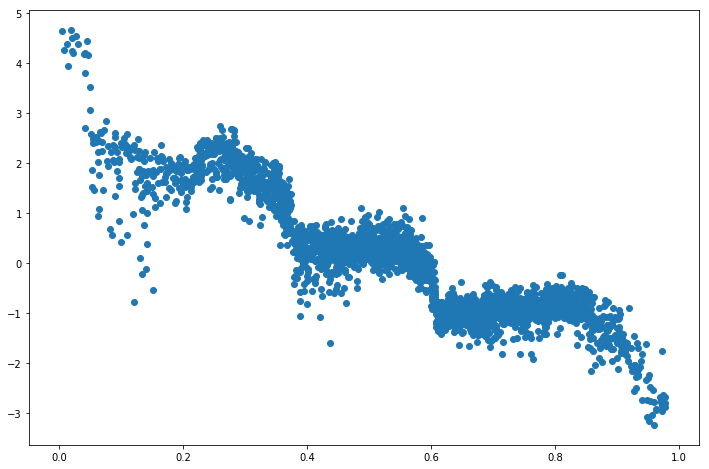

In [26]:
plt.scatter(satisfaction_level_value, satisfaction_level_logit)

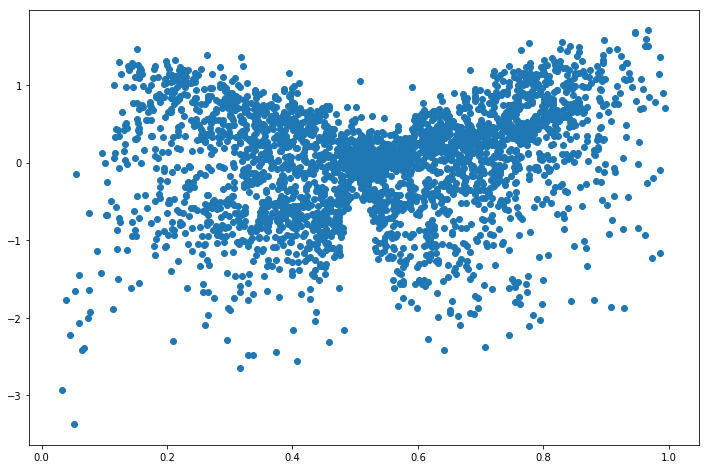

In [27]:
plt.scatter(last_evaluation_value, last_evaluation_logit)